In [3]:
from math import pi, sqrt
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt


In [32]:
#[Lauffer 1944]: diameter 109 +/- 16.65 nm
#[Ruigrok 1984]: diameter 115 +/- 12 nm

mean_diameter = (109.0+115.0)/2.0

sigma_diameter = (16.65+12)/2.0 #average

#[Ruigrok 1984]: mass 160 MDa +/- 17 MDa
sigma_mass = (17.0+24.0)/2.0

mean_mass = 160


In [33]:
#check if variation in  variation in volume corresponds to the variation in mass
# mass is only 
avg_radius = 57.5 
one_sigma_pos_rad = avg_radius + (sigma_diameter/2.0)
volume_sigma = (((4/3.0) * pi * (one_sigma_pos_rad)**2.0)/((4/3.0) * pi * (avg_radius)**2.0))-1.0
volume_sigma
avg_mass = 75.0
vol_one_sigma_mass = avg_mass*volume_sigma
vol_one_sigma_mass
#it doesn't

19.84851961247638

We know the variation in the diameter and therefore the volume. There is almost no variation in the overall spike mass, so we subtract that first. We would expect 19.8 MDa of variation if volume and mass were proportional, and see 17 MDa of variation. 

We therefore assume that mass and volume are proportional.



From [Li 2011] we see that envelope stiffness is strongly *negatively* correlated with size, so we assume that breaking force is, too.



In [159]:
#Extracted from [Li 2011] using https://apps.automeris.io/wpd/,

# count = np.array([2.9816513761467904,
# 6.0091743119266035,
# 15.045871559633028,
# 21.14678899082569,
# 17.93577981651376,
# 11.10091743119266,
# 11.972477064220184,
# 11.972477064220184,
# 15.458715596330272,
# 8.119266055045873,
# 19.174311926605505,
# 9.908256880733944,
# 6.834862385321103,
# 5.045871559633027,
# 7.018348623853214,
# 2.018348623853214,
# 1.0091743119266046])

count = np.array([ 3.,  6., 15., 21., 18., 11., 12., 12., 15.,  8., 19., 10.,  7.,
        5.,  7.,  2.,  1.]) #rounded


breaking_force = [0.24179620034542312,
0.33851468048359246,
0.4421416234887737,
0.5423143350604491,
0.6528497409326425,
0.753022452504318,
0.8186528497409327,
0.9395509499136444,
1.0466321243523315,
1.143350604490501,
1.2469775474956826,
1.3506044905008636,
1.4300518134715028,
1.5474956822107082,
1.6165803108808294,
1.7305699481865287,
1.9412780656303976]

In [176]:
def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - ((x - mean) / standard_deviation) ** 2)

popt, _ = curve_fit(gaussian, breaking_force, count)
mean_breaking_force = popt[0]
sigma_breaking_force = abs(popt[2]) #curve_fit can sometimes return negative.

print("Liposome breaking force {:.3f} sigma={:.3f} pN".format(mean_breaking_force, sigma_breaking_force))

#this could also include some of the non-infective mutants

Liposome breaking force 0.839 sigma=0.733 pN


In [192]:
#overriding because non-binomial

mean_breaking_force = 1.0
sigma_breaking_force = 0.45



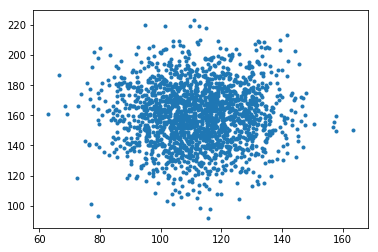

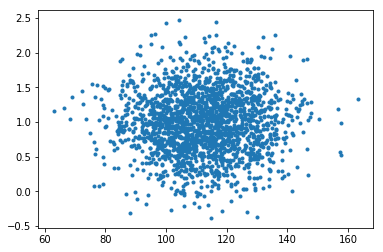

In [193]:
means = [mean_diameter, mean_mass, mean_breaking_force] #oh he's got the means all right.

var_diameter = (sigma_diameter**2.0)
var_mass = (sigma_mass**2.0)
var_breaking_force = (sigma_breaking_force**2.0)



covariance_matrix = np.array([[var_diameter, 0, 0], 
                              [0, var_mass, sigma_breaking_force * ],
                              [0, 0, var_breaking_force]])

diameter_samples,mass_samples,breaking_force_samples = np.random.multivariate_normal(means, covariance_matrix, 2000).T

diameter_samples = diameter_samples.T #first .T lets us access with ,, operator, second .T gets us our 1d array back
mass_samples = mass_samples.T
breaking_force_samples = breaking_force_samples.T 

plt.plot(diameter_samples,mass_samples, '.')
plt.figure()
plt.plot(diameter_samples,breaking_force_samples, '.')

0.9203444564047363

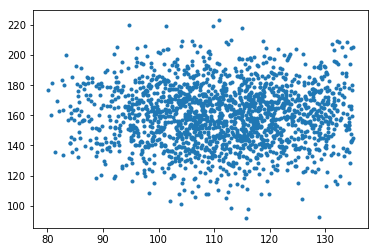

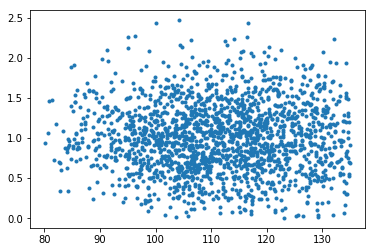

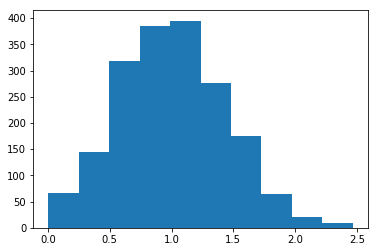

In [194]:

#choose only infectious particles [Lauffer 1944]
remove_indices = np.append(np.nonzero((diameter_samples < 80.0)), np.nonzero((diameter_samples > 135.0)))

#choose only positive breaking forces
remove_indices = np.append(remove_indices, np.nonzero(breaking_force_samples < 0.0))

remove_indices = np.unique(remove_indices)

diameter_samples = np.delete(diameter_samples, remove_indices)
mass_samples = np.delete(mass_samples, remove_indices)
breaking_force_samples = np.delete(breaking_force_samples, remove_indices)

plt.plot(diameter_samples,mass_samples, '.')
plt.figure()
plt.plot(diameter_samples,breaking_force_samples, '.')

#> "More than 95% puncture events occurred above 0.4 nN."
above_point_4 = np.shape(np.where(breaking_force_samples > 0.4))[1] / len(breaking_force_samples)
# about 75% before filtering and 84% after.
# probably because of the clipped normal. np multivariate doesn't support beyond normal,
# so that'll have to be good enough.

plt.figure()
plt.hist(breaking_force_samples)

above_point_4

We very simply extend [Yang 2015]'s analysis to include the distribution of viral particles. 

We have to continue using H3N1 rather than the target SARS-NCoV-2 because of an apparent lack of AFM data.

    The majority of virions (n = 78) may be described as spherical (axial ratio 1.2), the remainder are oval or   kidney-shaped with axial ratios up to 1.4 (n = 17) or more elongated with axial ratios as high as 7.7 (n = 15). The outer diameters of the spherical virions ranged from 84 to 170 nm (mean, 120 nm).

Note that, per [Lauffer 1944], of Inf A and B, "the infectious particles have diameters within the range 80 to 135[nm]".

[Yang 2015]'s MDCK plaque assay is already sensitive to infectivity; the extreme-sized non-infective mutants would already be filtered out. Their PCR assay might not be; the DNA of all non-infectious mutants would be considered.

[Yang 2015] use a minimum force of 400 pN, though their reference, [Li 2011], mention that

> More than 95% puncture events occurred above 0.4 nN.

This probably accounts for the high 100% threshold.

The distribution of breaking strengths in [Li 2011] (Figure 5b) is bimodal, and a naive gaussian fit does not produce the above 95% figure. Rather than implement a unimodal+bimodal covariant sampling function, we tweaked the gaussian parameters to fit. We hope that the deities of statistical best practice are not displeased.

The mass, diameter, and breaking force are presumably not independently distributed. The correlations between the three variables do not seem to be documented in the literature.

There seems to be little variation in the mass of the spike proteins; intact H3N1 is 161 MDa +/- 17, with spikes removed, 75 MDa +/- 17.  [Ruigrok 1984]  

The average stiffness of the liposome varies approximately linearly from 0.025 to 0.015 from 80 to 135 nm [Li 2011], plus a random distribution with approx. 0.0025 sigma. 

Size and weight are assumed to be uncorrelated with breaking strength.


From [Yang 2015], eq. 7,

$$A = \frac{q E_0}{\mu \sqrt{((2 \pi f_{res})^2 - (2 \pi f_{excite})^2)^2 + \left(\frac{(2 \pi f_{res})(2 \pi f_{excite})}{Q}\right)^2}}$$


The resonant frequency varies as $\sqrt{k/m^*}$.

Assuming (as Yang et al do) that the core and shell have 90% and 10% of the mass, 


In [198]:
mu = ((0.9*mass_samples) * (0.1*mass_samples))/(mass_samples) 

Now we run into a problem. We don't know the dependence of k, the spring constant, on any of the parameters.

Figure 4b in Yang is dependent on k vs f_res, and the overall absorption cross-section data in Figure 3b includes the sum of all the absorption cross-sections of all the variance.

In [1]:
resonant_frequencies = sqrt()

NameError: name 'pulse_power' is not defined

1250.0

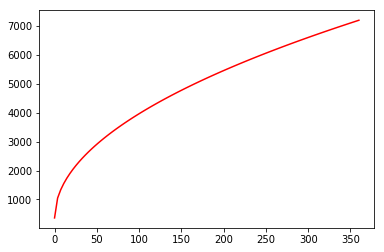

ValueError: x and y must have same first dimension, but have shapes (11999,) and (11998,)

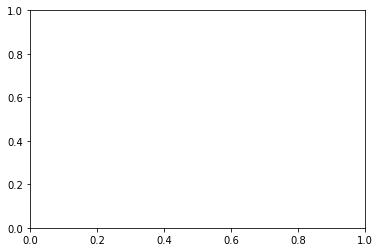